In this notebook, I compute the NN's predictions of precipitation for different amounts of gaussian blurring. We expect that blurring will reduce the expected amount of precipitation.

In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import torch
import gnl
import gnl.xarray
import seaborn as sns
import matplotlib.pyplot as plt
gnl.colorblind()

from src.data import open_data
from uwnet.thermo import lhf_to_evap, compute_apparent_source, integrate_q2, net_precipitation_from_training, \
    net_precipitation_from_prec_evap


def get_nn_prediction(model, ds):
    out= model.predict(ds)
    nn = -integrate_q2(out['QT'], ds.layer_mass) 
    return nn


def blur(arr, sigma):
    if not {'x', 'y'} <= set(arr.dims):
        raise ValueError
    if sigma <= 1e-8:
        raise ValueError
    
    return (arr.ndimage.gaussian_filter1d('x', sigma, mode='wrap')
     .ndimage.gaussian_filter1d('y', sigma, mode='nearest'))


def blur_dataset(data, sigma):
    data_vars = {}
    for x in data:
        try:
            data_vars[x] = blur(data[x], sigma)
        except ValueError:
            data_vars[x] = data[x]
            
    return xr.Dataset(data_vars)


def predict_precip_for_blurred(sigma):
    return get_nn_prediction(model, blur_dataset(ds, sigma))


def compute_precip_for_blurring_radii(sigmas):
    blurred = [predict_precip_for_blurred(rad) for rad in sigmas]
    return xr.concat(blurred, dim=sigmas).rename({'concat_dim': 'sigma'})


def plot_zonal_avg_precip_for_sigma(precips):
    precips = precips.assign_coords(y=precips.y/1e6)
    sns.FacetGrid(avg.to_dataframe(name='NetPrec').reset_index(), hue='sigma', aspect=1.61,
                 palette=sns.color_palette('viridis', n_colors=len(precips.sigma)))\
    .map(plt.plot, 'y', 'NetPrec')\
    .add_legend()

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [6]:
blur_radii = [0.0, .1, .2, .5, .75, 1.0, 2.0, 10.0]

ds = open_data('training').isel(time=slice(0, 10))
model = torch.load("../models/277/3.pkl")
precips = compute_precip_for_blurring_radii(blur_radii)
avg = precips.mean(['x', 'time'])

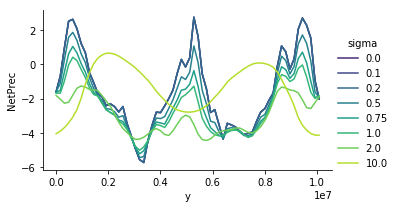

In [7]:
plot_zonal_avg_precip_for_sigma(avg)

Our suspicions are confirmed! This shows that blurring the data greatly reduces the expected amount of net precipitation.

# Precip Snapshots

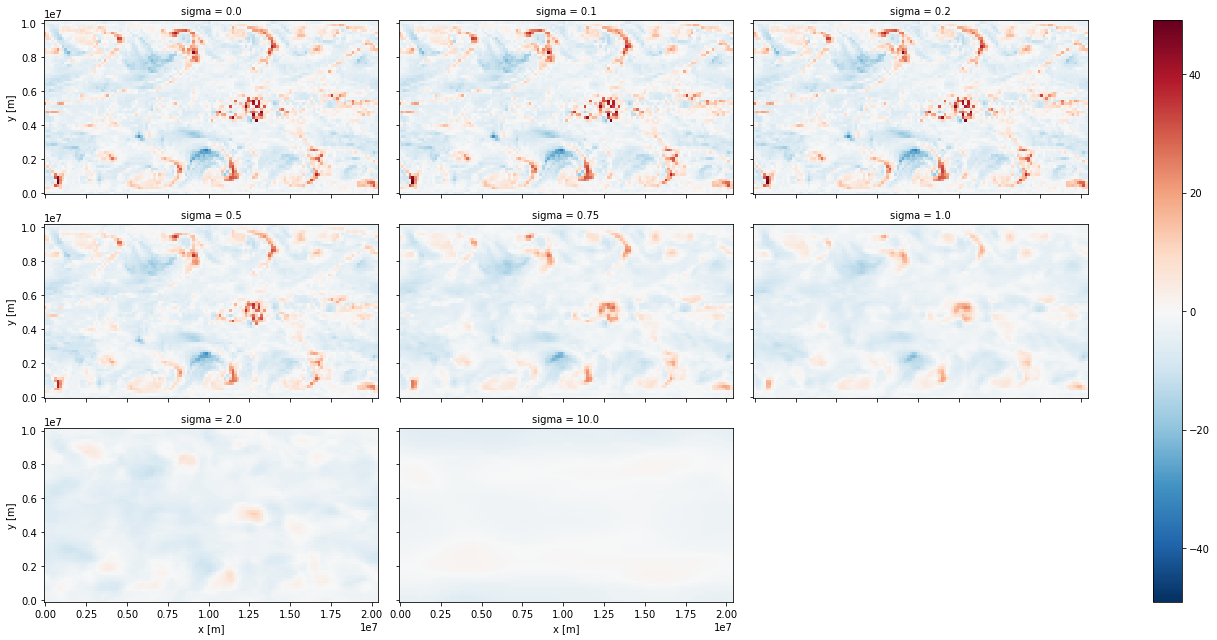

In [16]:
precips.isel(time=9).plot(col='sigma', col_wrap=3, aspect=2)